## Import the necessay packages

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Load the Dataset

In [ ]:
df = pd.read_csv("Retail_Transaction_Dataset.csv")
df.head()

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount
0,109318,C,7,80.079844,12/26/2023 12:32,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764
1,993229,C,4,75.195229,8/5/2023 0:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546
2,579675,A,8,31.528816,3/11/2024 18:51,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651
3,799826,D,5,98.880218,10/27/2023 22:00,PayPal,"87522 Sharon Corners Suite 500\nLake Tammy, MO...",Books,6.686337,461.343769
4,121413,A,7,93.188512,12/22/2023 11:38,Cash,"0070 Michelle Island Suite 143\nHoland, VA 80142",Electronics,4.030096,626.030484


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CustomerID          100000 non-null  int64  
 1   ProductID           100000 non-null  object 
 2   Quantity            100000 non-null  int64  
 3   Price               100000 non-null  float64
 4   TransactionDate     100000 non-null  object 
 5   PaymentMethod       100000 non-null  object 
 6   StoreLocation       100000 non-null  object 
 7   ProductCategory     100000 non-null  object 
 8   DiscountApplied(%)  100000 non-null  float64
 9   TotalAmount         100000 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 7.6+ MB


In [ ]:
df.ProductCategory.value_counts()

,count
ProductCategory,
Clothing,25056
Books,25031
Electronics,24990
Home Decor,24923


In [ ]:
# Define new target counts
target_counts = {
    'Clothing': 35000,
    'Books': 15000,
    'Electronics': 20000,
    'Home Decor': 10000
}

# Resampling function
def resample_category(df, category, target_count):
    current_count = len(df[df['ProductCategory'] == category])

    if current_count < target_count:
        # Oversample by duplicating existing rows with slight variations
        extra_samples = df[df['ProductCategory'] == category].sample(target_count - current_count, replace=True)
        extra_samples['Price'] = extra_samples['Price'] * np.random.uniform(0.95, 1.05, len(extra_samples))
        extra_samples['TotalAmount'] = extra_samples['Quantity'] * extra_samples['Price'] * (1 - extra_samples['DiscountApplied(%)'] / 100)
        return pd.concat([df[df['ProductCategory'] == category], extra_samples], ignore_index=True)

    elif current_count > target_count:
        # Undersample by randomly removing rows
        return df[df['ProductCategory'] == category].sample(target_count, random_state=42)

    else:
        return df[df['ProductCategory'] == category]

# Apply resampling to each category
resampled_dfs = [resample_category(df, cat, count) for cat, count in target_counts.items()]

# Combine into final DataFrame
df_imbalanced = pd.concat(resampled_dfs, ignore_index=True)

# Check new value counts
print("After Resampling:\n", df_imbalanced['ProductCategory'].value_counts())

After Resampling:
 ProductCategory
Clothing       35000
Electronics    20000
Books          15000
Home Decor     10000
Name: count, dtype: int64


In [ ]:
df = df_imbalanced.copy()

In [ ]:
df.PaymentMethod.value_counts()

,count
PaymentMethod,
Credit Card,20200
PayPal,20042
Cash,20037
Debit Card,19721


In [ ]:
df_synthetic = df[df['PaymentMethod'] == 'PayPal'].copy()
df_synthetic['TotalAmount'] *= random.uniform(0.7, 1.3)  # Small variation
df_synthetic['Quantity'] += random.randint(-1, 1)

df_imbalanced = pd.concat([df, df_synthetic])

# Check new distribution
print(df_imbalanced['PaymentMethod'].value_counts())


PaymentMethod
PayPal         40084
Credit Card    20200
Cash           20037
Debit Card     19721
Name: count, dtype: int64


In [ ]:
df = df_imbalanced.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100042 entries, 0 to 79996
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CustomerID          100042 non-null  int64  
 1   ProductID           100042 non-null  object 
 2   Quantity            100042 non-null  int64  
 3   Price               100042 non-null  float64
 4   TransactionDate     100042 non-null  object 
 5   PaymentMethod       100042 non-null  object 
 6   StoreLocation       100042 non-null  object 
 7   ProductCategory     100042 non-null  object 
 8   DiscountApplied(%)  100042 non-null  float64
 9   TotalAmount         100042 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 8.4+ MB


## Data Cleaning and preprocessing

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

,0
CustomerID,0
ProductID,0
Quantity,0
Price,0
TransactionDate,0
PaymentMethod,0
StoreLocation,0
ProductCategory,0
DiscountApplied(%),0
TotalAmount,0


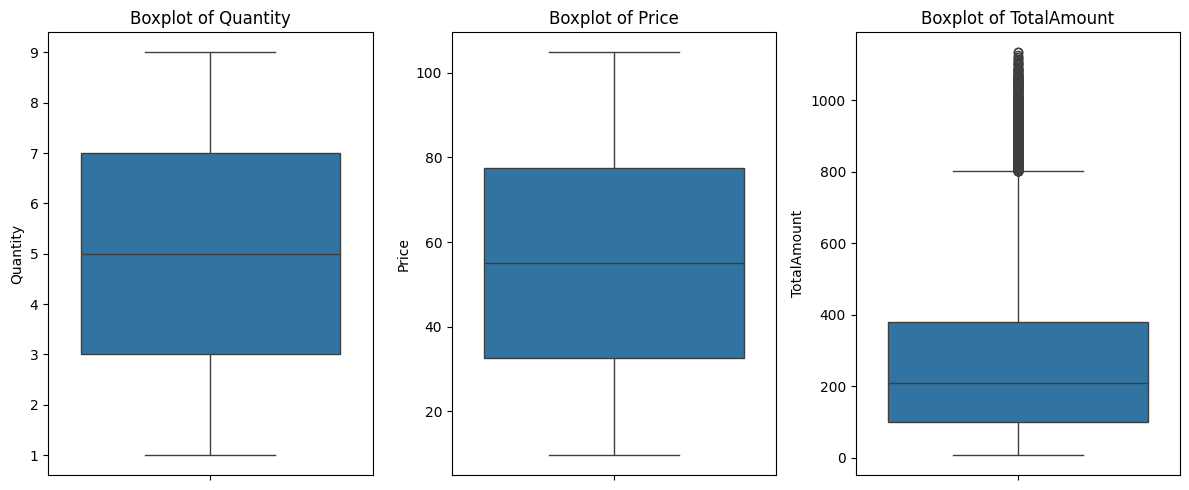

In [ ]:
# Select numerical columns for outlier detection
numerical_columns = ["Quantity", "Price", "TotalAmount"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


Use Capping method to remove the outliers - Winsorization


In [ ]:
Q1 = df["TotalAmount"].quantile(0.25)
Q3 = df["TotalAmount"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#capping
df["TotalAmount_Capped"] = np.clip(df["TotalAmount"], lower_bound, upper_bound)

print(df[["TotalAmount", "TotalAmount_Capped"]].describe())


         TotalAmount  TotalAmount_Capped
count  100042.000000       100042.000000
mean      262.565970          261.455899
std       198.708277          195.241420
min         8.059789            8.059789
25%        99.974307           99.974307
50%       210.606733          210.606733
75%       380.850955          380.850955
max      1133.546700          802.165928


Text(0.5, 1.0, 'Boxplot of TotalAmount')

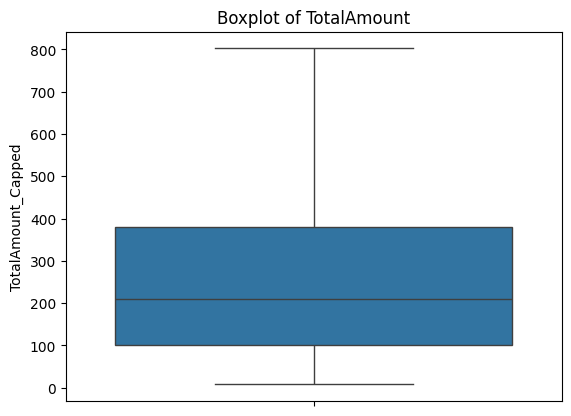

In [ ]:
sns.boxplot(y=df["TotalAmount_Capped"])
plt.title(f"Boxplot of {col}")

## Exploratory Data Analysis (EDA)

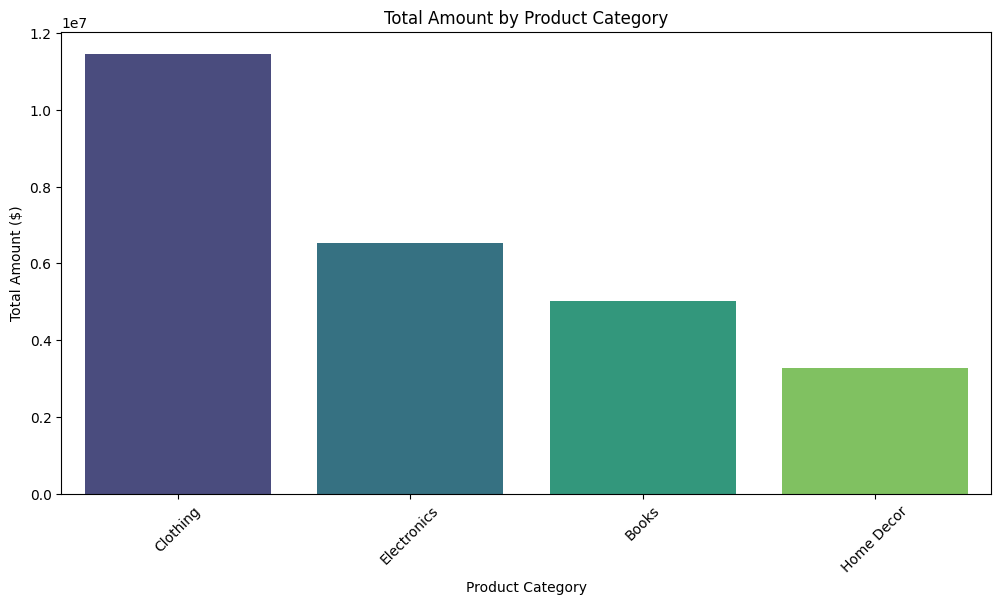

In [ ]:
# Aggregate total amount by product category
category_total_amount = df.groupby('ProductCategory')['TotalAmount'].sum().round(3).reset_index()

# Sort categories by total amount
category_total_amount_sorted = category_total_amount.sort_values(by='TotalAmount', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='ProductCategory', y='TotalAmount', hue='ProductCategory', data=category_total_amount_sorted, palette="viridis", legend=False)

plt.title('Total Amount by Product Category')
plt.xticks(rotation=45)
plt.ylabel('Total Amount ($)')
plt.xlabel('Product Category')

plt.show()

**Insights:**

**Clothing (Highest Revenue)** - Seasonal Promotions & Flash Sales, Influencer Collaborations

**Electronics (Second Highest)** - Bundle Discounts, Tech Reviews & Comparisons

**Books (Mid-Level Revenue)** - Bulk Purchase Discounts

**Home Decor (Lowest Revenue)** - Seasonal Collections & Festive Discounts

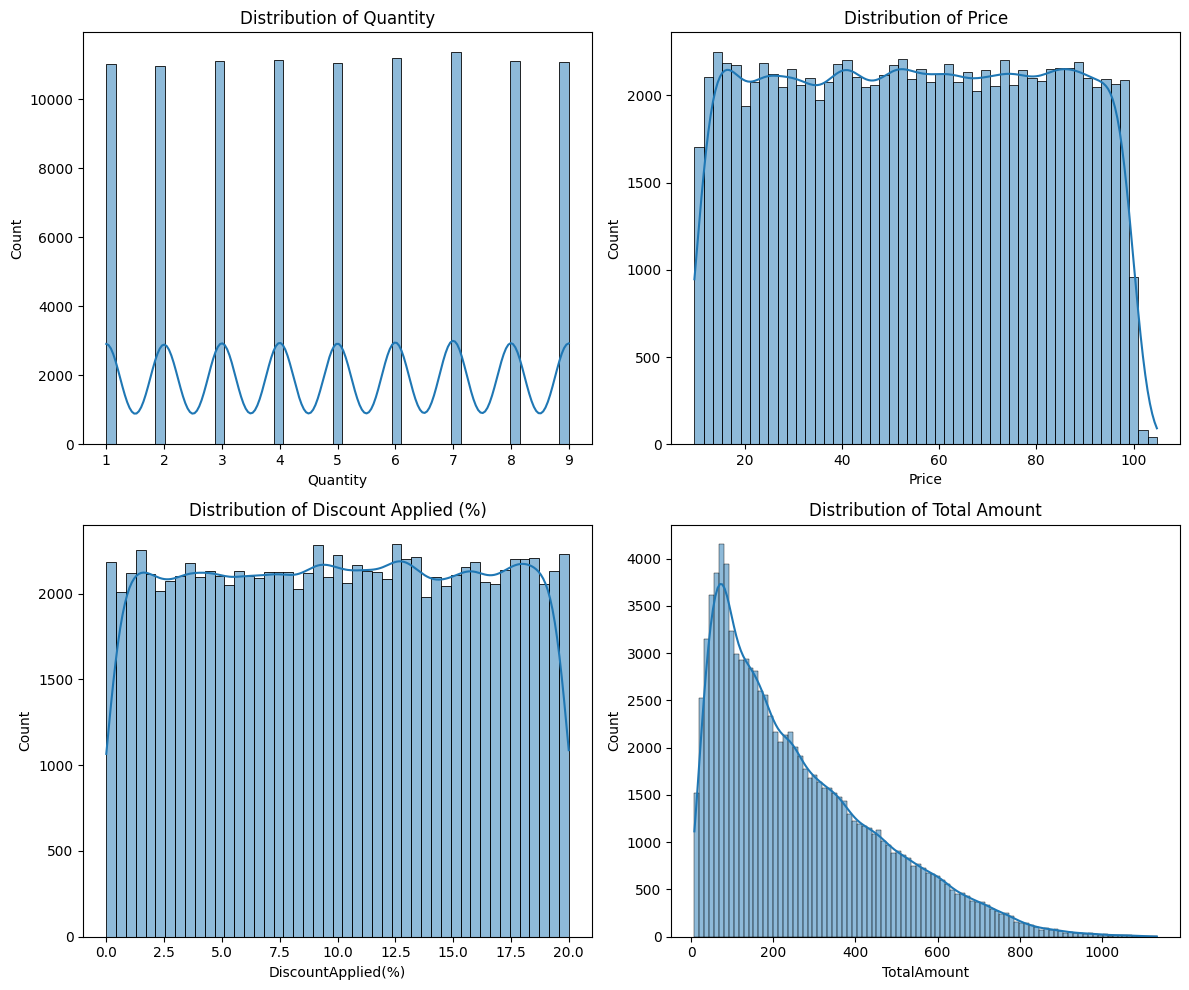

In [ ]:
# Distribution of key numerical features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(df['Quantity'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Quantity')

sns.histplot(df['Price'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Price')

sns.histplot(df['DiscountApplied(%)'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Discount Applied (%)')

sns.histplot(df['TotalAmount'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Total Amount')

plt.tight_layout()
plt.show()

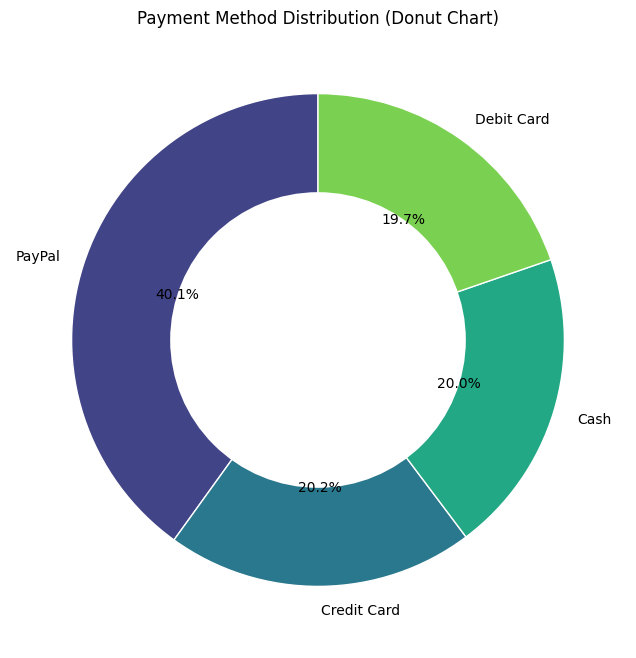

In [ ]:
plt.figure(figsize=(8, 8))
sizes = df['PaymentMethod'].value_counts()
plt.pie(sizes, labels=sizes.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(sizes)), wedgeprops={'edgecolor': 'white'}, startangle=90)
plt.gca().add_artist(plt.Circle((0,0),0.6,fc='white'))  # Create the donut effect
plt.title('Payment Method Distribution (Donut Chart)')
plt.show()

**Insights:**

**PayPal-Focused Strategy (Largest Share - 40.1%)** - Offer cashback or discounts for PayPal payments.

**Credit Card & Cash Strategies (Around 20% Each)** - Collaborate with banks to provide EMI options and cashback for credit card users.

**Debit Card Strategy (19.7%)** - Advertise zero or low transaction fees for debit card users.

In [ ]:
# Time series: Transactions over time -> 'TransactionDate' is in string format, convert it to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df.set_index('TransactionDate', inplace=True)

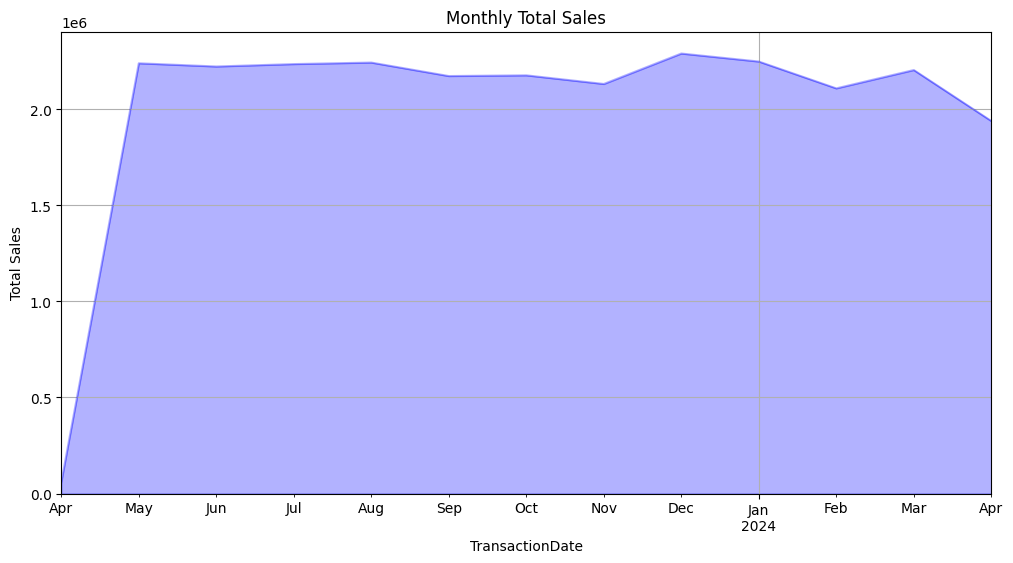

In [ ]:
#total sales over time
plt.figure(figsize=(12, 6))
df['TotalAmount'].resample('ME').sum().plot(kind='area', alpha=0.3, color='b')
plt.title('Monthly Total Sales')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

## Analysis

**Customer Lifetime Value (CLV)**

Estimate the total revenue a customer is expected to generate over their lifetime.

CLV=∑(Quantity×Price)

Low: Customers with CLV ≤ 500

Medium: Customers with 500 < CLV ≤ 2000

High: Customers with CLV > 2000



In [ ]:
df['Revenue'] = df['Quantity'] * df['Price']
df_clv = df.groupby('CustomerID')['Revenue'].sum().reset_index()
df_clv.rename(columns={"Revenue": "CLV"}, inplace=True)

bins = [0, 500, 2000, df_clv['CLV'].max()]  # Define range
labels = ['Low', 'Medium', 'High']

df_clv['CLV_Segment'] = pd.cut(df_clv['CLV'], bins=bins, labels=labels, include_lowest=True)

CLV_Segment
Low       48496
Medium    18617
High        537
Name: count, dtype: int64


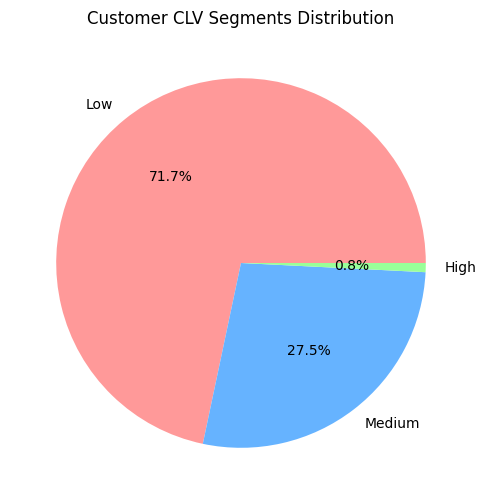

In [ ]:
#Count Customers in Each Segment
segment_counts = df_clv['CLV_Segment'].value_counts()
print(segment_counts)

plt.figure(figsize=(6, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Customer CLV Segments Distribution')
plt.show()

**Insights:**

**Low CLV Customers (73.0%)** - Convert them into repeat customers and increase their spending. Offer discounts, loyalty points, or incentives to encourage repeat purchases.

**Medium CLV Customers (26.4%)** - Encourage them to buy more frequently and move them to the High CLV segment. Offer subscription-based services to create recurring revenue.

**High CLV Customers (0.7%)** - Provide first access to new products, special discounts, and premium customer support.

**Top 10 location which has average CLV**

                                           StoreLocation          CLV
35050        56326 Denise Gateway\nButlershire, ID 81650  5595.822437
19228  311 Brown Street Suite 692\nMelissaberg, AS 78596  5503.592724
4351              0698 Scott Green\nPort Kelly, GA 79125  5235.945765
58108  931 Daniel Junction Apt. 734\nCarolborough, KS...  5233.298593
15307          24713 Hill Views\nNorth Michael, DE 37975  5211.140488
45958       7379 Morton Parks\nNew Ashleymouth, VT 66914  5054.475158
8948          145 Collins Cliff\nSouth Katrina, CO 81835  4787.629407
21910      353 Wolfe Corners\nSouth Deniseland, VI 43564  4759.528146
24721  3972 Daniels Parkway Apt. 818\nCarolineport, O...  4750.811069
25981        4172 Carrie Creek\nWest Meganberg, SC 53504  4750.811069


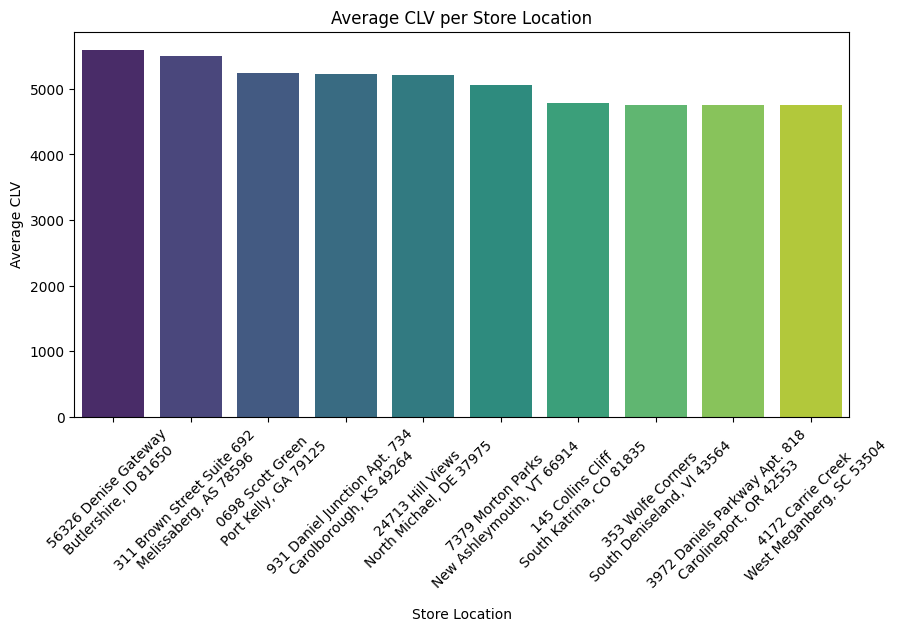

In [ ]:
# Merge CLV data with the original dataset
df_clv_location = df.merge(df_clv, on="CustomerID", how="left")

# Compute Average CLV per Store
clv_by_location = df_clv_location.groupby("StoreLocation")['CLV'].mean().reset_index()

# Sort by CLV
clv_by_location = clv_by_location.sort_values(by="CLV", ascending=False).head(10)
print(clv_by_location)

# Visualizing CLV per Store Location
plt.figure(figsize=(10, 5))
sns.barplot(x="StoreLocation", y="CLV", data=clv_by_location, hue="StoreLocation", palette="viridis", legend=False)
plt.xticks(rotation=45)
plt.xlabel("Store Location")
plt.ylabel("Average CLV")
plt.title("Average CLV per Store Location")
plt.show()


**Store Performance Analysis**

Identify least-performing stores and optimize stock levels.

Compare revenue across different store locations.

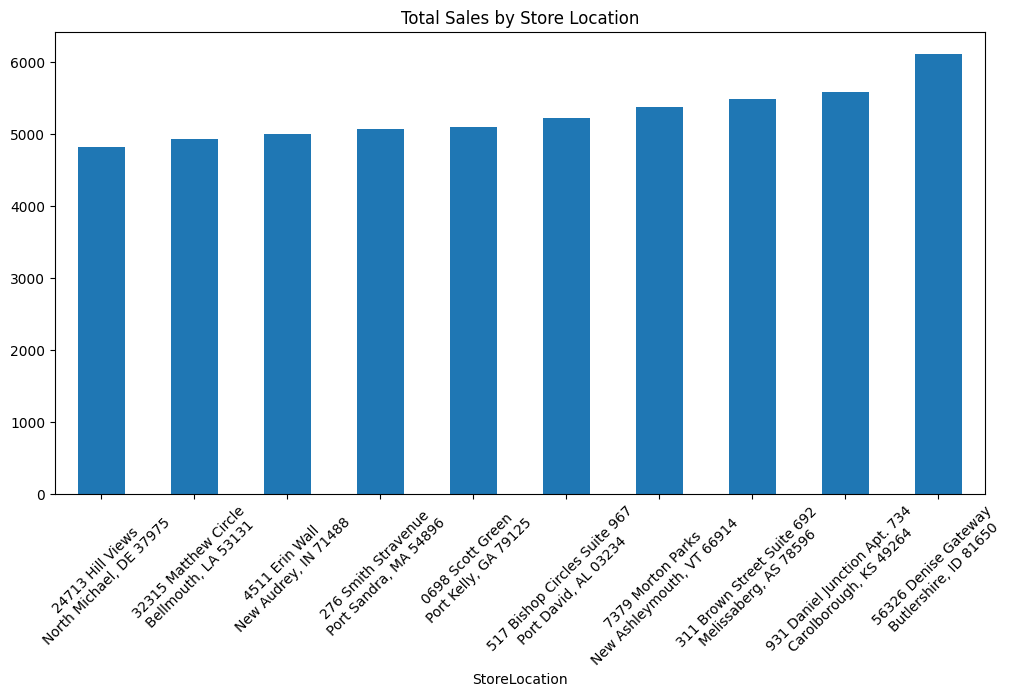

In [ ]:
plt.figure(figsize=(12,6))
df.groupby('StoreLocation')['TotalAmount'].sum().sort_values().tail(10).plot(kind='bar')
plt.title('Total Sales by Store Location')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.reset_index(inplace=True)

**Customer segmentation using KMeans**

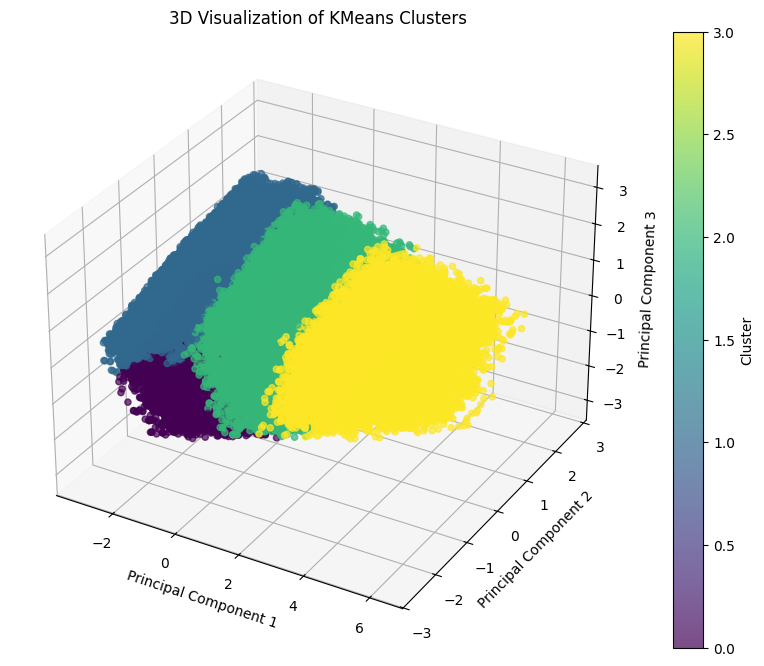

In [ ]:
# Exclude non-numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

#KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

pca_3d = PCA(n_components=3)
reduced_data_3d = pca_3d.fit_transform(scaled_data)

#3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_data_3d[:, 0], reduced_data_3d[:, 1], reduced_data_3d[:, 2], c=clusters, cmap='viridis', alpha=0.7)
ax.set_title('3D Visualization of KMeans Clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
fig.colorbar(scatter, label='Cluster')

plt.show()


**Churn Analysis**

Churn analysis involves identifying customers who are likely to stop using a service or product

Recency: Time since the last purchase.

Frequency: Number of transactions in the past months.

Monetary: Total spending in the past months.

In [ ]:
# Convert 'TransactionDate' to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

In [ ]:
# Calculate Recency (days since last purchase)
latest_purchase = df.groupby('CustomerID')['TransactionDate'].max()
recency = (pd.to_datetime('today') - latest_purchase).dt.days

# Calculate Frequency (number of transactions)
frequency = df.groupby('CustomerID')['TransactionDate'].count()

# Calculate Monetary (total spending)
monetary = df.groupby('CustomerID')['TotalAmount'].sum()


In [ ]:
# Merge these features into a new DataFrame
churn_data = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})

In [ ]:
#thresholds
recency_threshold = 90  # Days since last purchase
frequency_threshold = 3  # Number of purchases in the last 6 months
monetary_threshold = 100  # Total amount spent in the last 6 months

churn_data['Churn'] = ((churn_data['Recency'] > recency_threshold) &
                       (churn_data['Frequency'] < frequency_threshold) &
                       (churn_data['Monetary'] < monetary_threshold))

In [ ]:
# Convert boolean values to 1 (churned) and 0 (not churned)
churn_data['Churn'] = churn_data['Churn'].astype(int)

# Check the resulting churn_data
print(churn_data.head())

            Recency  Frequency     Monetary  Churn
CustomerID                                        
14              569          1   256.232791      0
42              647          2  1145.588363      0
49              630          1    21.399047      1
59              556          1   139.612036      0
65              618          2  1248.944325      0


In [ ]:
# Count active vs churned customers
active_customers = churn_data[churn_data['Churn'] == False].shape[0]
churned_customers = churn_data[churn_data['Churn'] == True].shape[0]

print(f"Active Customers: {active_customers}")
print(f"Churned Customers: {churned_customers}")


Active Customers: 54684
Churned Customers: 12966


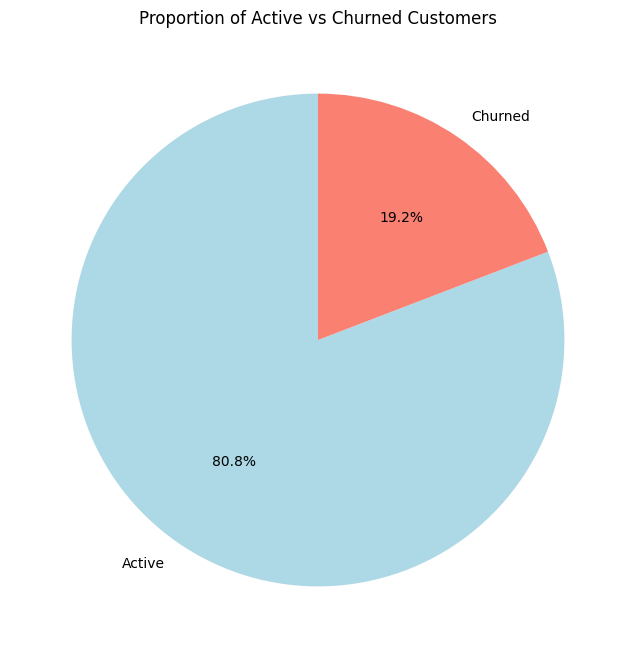

In [ ]:
# Pie chart for active vs churned customers
churn_counts = churn_data['Churn'].value_counts()
labels = ['Active', 'Churned']
plt.figure(figsize=(8, 8))
plt.pie(churn_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Proportion of Active vs Churned Customers')
plt.show()

**Customer Retention & Loyalty**

Find the  Repeat Purchase Rate (RPR)

In [ ]:
repeat_customers = churn_data[churn_data['Frequency'] > 1]
repeat_rate = len(repeat_customers) / len(df) * 100
print(f"Repeat Purchase Rate: {repeat_rate:.2f}%")

Repeat Purchase Rate: 24.36%


A Repeat Purchase Rate (RPR) of 24.32% means that about 1 in 4 customers has made multiple purchases

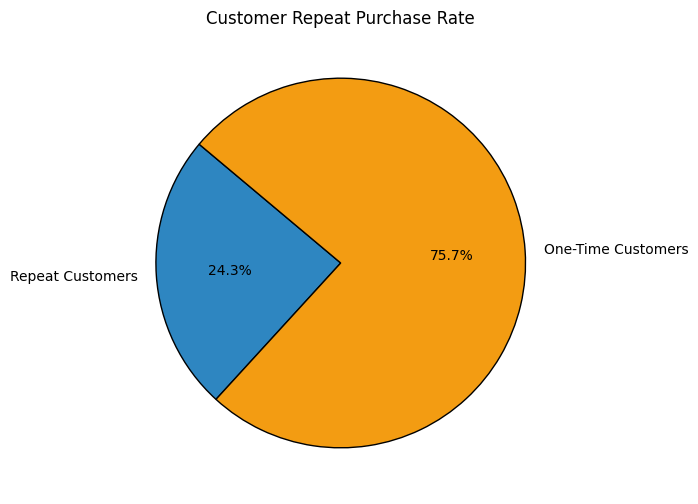

In [ ]:
repeat_rate = 24.32
one_time_rate = 100 - repeat_rate

labels = ["Repeat Customers", "One-Time Customers"]
sizes = [repeat_rate, one_time_rate]
colors = ["#2E86C1", "#F39C12"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Customer Repeat Purchase Rate")
plt.show()


**Insights:**

Offer discounts, points, or exclusive deals for repeat customers.
Example: "Buy 3 times, get 10% off on the next order!"

Remind customers via sms or email to repurchase before they churn.
Example: "It’s been a while since your last order. Here’s a 15% discount!"

In [ ]:
churn_data = churn_data.reset_index()

# Merge churn_data with df
df = df.merge(churn_data[['CustomerID', 'Churn']], on='CustomerID', how='left')

**Find the total churned revenue**

In [ ]:
churned_revenue = df[df['Churn'] == True]['TotalAmount'].sum()
total_revenue = df['TotalAmount'].sum()
revenue_loss_percentage = (churned_revenue / total_revenue)*100

print(f"Revenue Lost Due to Churn: {revenue_loss_percentage:.2f}%")
print(f"Churned revenue: {churned_revenue:.2f}")

Revenue Lost Due to Churn: 2.96%
Churned revenue: 776698.23


**Cohort-Based Churn Analysis**

Tracks how different groups of customers (cohorts) churn over time

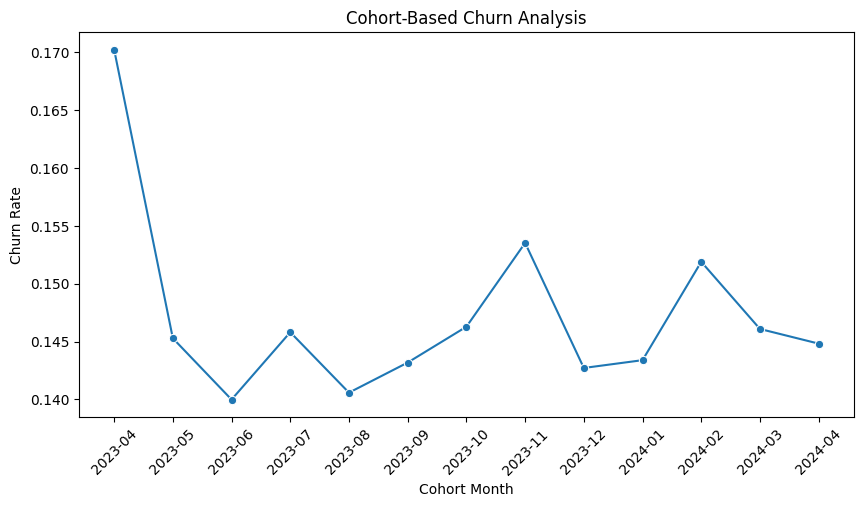

In [ ]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['CohortMonth'] = df['TransactionDate'].dt.to_period('M')

cohort_churn = df.groupby('CohortMonth')['Churn'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=cohort_churn.index.astype(str), y=cohort_churn.values, marker='o')
plt.xlabel("Cohort Month")
plt.ylabel("Churn Rate")
plt.title("Cohort-Based Churn Analysis")
plt.xticks(rotation=45)
plt.show()

**Insights:**

Identify customers from high-churn cohorts (e.g., Apr 2023, Oct 2023, Feb 2024) and offer personalized discounts or exclusive content.

Collect feedback from churned users to understand why they left.

Offer discounts or cashback on repeated purchases for cohorts showing early churn.